# Определение стоимости автомобилей

**Контекст**  
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**  
Данные находятся в файле /datasets/autos.csv.  

Пространство признаков:
* DateCrawled — дата скачивания анкеты из базы;
* VehicleType — тип автомобильного кузова;
* RegistrationYear — год регистрации автомобиля;
* Gearbox — тип коробки передач;
* Power — мощность (л. с.);
* Model — модель автомобиля;
* Kilometer — пробег (км);
* RegistrationMonth — месяц регистрации автомобиля;
* FuelType — тип топлива;
* Brand — марка автомобиля;
* Repaired — была машина в ремонте или нет;
* DateCreated — дата создания анкеты;
* NumberOfPictures — количество фотографий автомобиля;
* PostalCode — почтовый индекс владельца анкеты (пользователя);
* LastSeen — дата последней активности пользователя.

Целевой признак
* Price — цена (евро)  

**Инструкция**  
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.  

*Основные шаги:*  

1) Загрузить данные в переменную;  
2) Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их;  
3) Подготовить выборки для обучения моделей;  
4) Обучить разные модели: одна из моделей — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры;  
5) Проанализировать время обучения, время предсказания и качество моделей;  
6) Опираясь на критерии заказчика, выбратье лучшую модель, проверить её качество на тестовой выборке.  

*Примечания:*

    а) Для оценки качества моделей применяйте метрику RMSE;  
    б) Значение метрики RMSE должно быть меньше 2500;  
    в) Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга;  
    г) Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её;  
    д) Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра;  
    е) Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del (del features_train). 

## Подготовка данных

### Загрузка данных и библиотек и оценка первичной информации о данных

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
# подгружаем данные
pth0_1 = '/datasets/autos.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/autos.csv'

if os.path.exists(pth0_1):
    data = pd.read_csv(pth0_1)
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data = pd.read_csv(pth0_2)
    print('data import from local storage')
else:
    print('Check the PATH to data file please')

data import from jupyterhub


Вывод первичной информации о данных

In [3]:
print(data.head())
print(data.info())
print(data.describe())

           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00

Посчитаем фактическое кол-во пропусков, а затем количество пропусков по столбцам в процентах по отношению ко всем значениям столбца.  
Для наглядности зальём тепловым градиентом.

In [4]:
display(data.isna().sum())
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


**Выводы**

1. Можно перевести все столбцы с датами в datetime64;  
2. В столбце Price минимальная цена 0;
3. В столбце RegistrationYear есть некорректные значения года регистрации, об этом говорят максимальные и минимальные значения;
4. В столбце Power есть некорректные значения мощности двигателя, об этом говорит минимальное значение;
5. В столбце с пробегом (Kilometer) начиная со второго квантиля (50%) значения упираются в 150000 км, скорее всего это какое-то искусственное ограничение, однако в реальной жизни параметр пробега оказывает существенное влияние на стоимость авто;
6. В столбце RegistrationMonth встречаются нулевые значения, что противоречит логике.

### Предобработка данных

#### Пространство признаков

Можно определиться с пространством признаков для будущей модели, то есть определить наиболее значимые признаки.  
Далее пройдемся по признакам, значимых для нашей модели:
  * *VehicleType*  
  Тип кузова определяет ее возможности. Чем их больше, тем выше цена. Но одна и та же модель может выпускаться с разныими типами кузовов.    
  * *RegistrationYear*  
  Год регистрации определяет возраст машины. Соответвенно, чем больше возраст, тем меньше цена. За редким исключением винтажной классики.
  * *Gearbox*  
  Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции и удобства эксплуатации.
  * *Power*  
  Мощность в лошадиных силах напрямую влияют на цену, увеличивая её.
  * *Model*  
  В совокупности с типом машины и брендом може влиять на популярность у покупателей.
  * *Kilometer*  
  Чем больше пробег, тем меньше ее надежность и соответсвенно цена, также этот признак часто связан с возрастом авто.
  * *FuelType*  
  Тип топлива определяет конструкцию двигателя внутреннего сгорания, а также будущие расходы на топливо.
  * *Brand*  
  Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
  * *Repaired*  
  Если машина побывала в ДТП, то ее констукция уже видоизменена, следовательно, надежность и качество ниже, как и цена.

Определившись с признаковым пространством, создадим новый датафрейм, включающий указанные признаки и целевой признак.

In [5]:
df = data[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'Price']]

In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

#### Оценка пропусков и дубликатов данных

In [7]:
display(pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm'))
print('Количество дубликатов:', df.duplicated().sum())
print('Это составляет процентов от всех записей:', df.duplicated().sum() / len(df) * 100)

,0
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
FuelType,9.000000
Brand,0.000000
Repaired,20.000000
Price,0.000000


Количество дубликатов: 45040
Это составляет процентов от всех записей: 12.709915370701161


Не смотря на значительное количество, явные дубликаты необходимо удалить.

In [8]:
df = df.drop_duplicates()
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


В целом, типы данных в столбцах релевантные, но имеются пропуски значений.  
Необходимо продумать стратегии устранения пропусков для каждого отдельного признака.  
Вероятно, заполнение пропусков лучше начать с **целевого признака**.

#### Обработка целевого признака, столбец `Price`

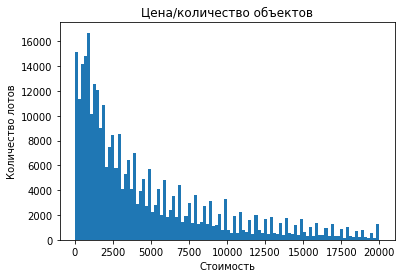

In [9]:
# визуально оценим распределение значений, построим гистограмму
plt.hist(df['Price'], bins=100, range=(0,20000))
plt.title('Цена/количество объектов')
plt.xlabel('Стоимость')
plt.ylabel('Количество лотов')
plt.show()

Очевидно, что стоимость машин около 0 соотвествует лотам, обладающим сильными дефектами, либо относящимся к рекламным объявлениям.  
Такие объявления можно удалить.

In [10]:
# оценим количество
print('Лотов дешевле 10 евро:', df.loc[data['Price'] < 10]['Price'].count())
print('В процентах по отношению к общему количеству строк:', df.loc[data['Price'] < 10]['Price'].count() / len(df))
print('Лотов дешевле 100 евро:', df.loc[data['Price'] < 100]['Price'].count())
print('В процентах по отношению к общему количеству строк:', df.loc[data['Price'] < 100]['Price'].count() / len(df))

Лотов дешевле 10 евро: 10041
В процентах по отношению к общему количеству строк: 0.03246058403835399
Лотов дешевле 100 евро: 11281
В процентах по отношению к общему количеству строк: 0.03646926088404256


Сложно представить хоть немного адекватный автомобиль дешевле 100 евро.  
Удалим все объявления с ценой менее 100 евро.

In [11]:
df = df.query('Price >= 100')
df.loc[df['Price'] < 10]['Price'].count()

0

Проверим, не изменилось ли распределение целевого признака после удаления объявлений с некорректной ценой.

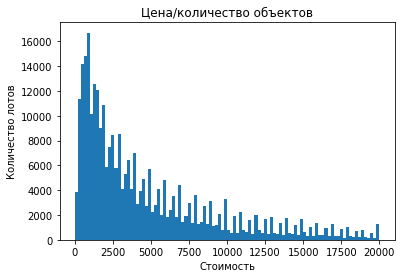

In [12]:
plt.hist(df['Price'], bins=100, range=(0,20000))
plt.title('Цена/количество объектов')
plt.xlabel('Стоимость')
plt.ylabel('Количество лотов')
plt.show()

#### Обрабатываем столбец `RegistrationYear`

Далее обработаем данные в столбце **RegistrationYear**.   
Не смотря на отсутствие пропусков, в столбце имеются некорректные значения.

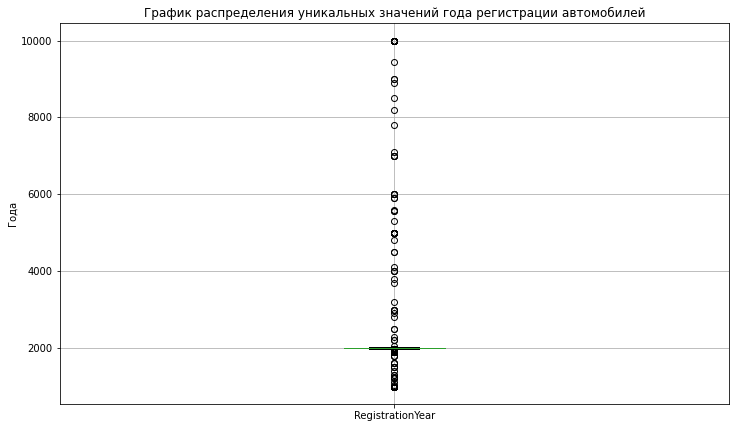

In [13]:
# оценим визуально
df.boxplot(['RegistrationYear'], figsize=(12,7))
plt.title('График распределения уникальных значений года регистрации автомобилей')

plt.ylabel('Года')
plt.show()

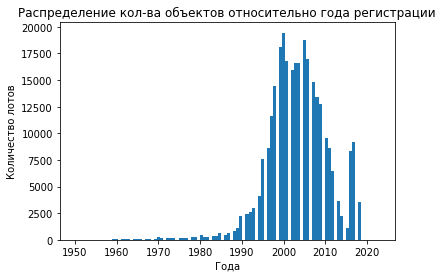

In [14]:
plt.hist(df['RegistrationYear'], bins=100, range=(1950,2023))
plt.title('Распределение кол-ва объектов относительно года регистрации')
plt.xlabel('Года')
plt.ylabel('Количество лотов')
plt.show()

In [15]:
# проверим дату последнего скачивания анкеты
data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [16]:
df.RegistrationYear.sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 8888, 9000, 9450, 9999])

In [17]:
df.RegistrationYear.value_counts().tail(70)

1955    13
1957    13
5000    12
1951    10
1937    10
        ..
1949     1
2222     1
5300     1
8888     1
2290     1
Name: RegistrationYear, Length: 70, dtype: int64

Как видно и графиков и цифр выше, можно исключить все значения до 1950 года и после 2016.

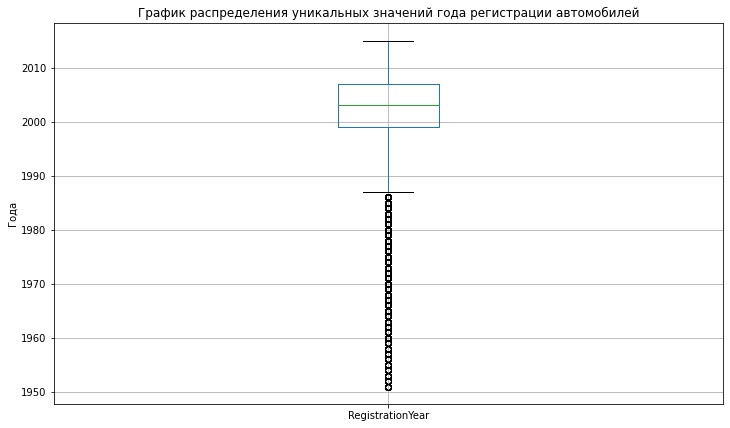

In [18]:
df = df.query('1950 < RegistrationYear < 2016')
df.boxplot(['RegistrationYear'], figsize=(12,7))
plt.title('График распределения уникальных значений года регистрации автомобилей')

plt.ylabel('Года')
plt.show()

#### Обрабатываем пропуски в столбцах `Gearbox`, `Rapaired`, `Model`.

Есть три близкосвязанных параметра: `Brand`, `Model` & `VehicleType`. Но ни один из них, ни сочетания двух не определяют однозначно друг друга или третьего. Поэтому у нас не получится заполнить пропуски значений по этим столбцам на основании имеющихся данных.

In [19]:
display(df['Gearbox'].sort_values().unique())
print(df['Gearbox'].value_counts())

array(['auto', 'manual', nan], dtype=object)

manual    209809
auto       55234
Name: Gearbox, dtype: int64


In [20]:
display(df['Repaired'].sort_values().unique())
print(df['Repaired'].value_counts())

array(['no', 'yes', nan], dtype=object)

no     198241
yes     28945
Name: Repaired, dtype: int64


In [21]:
print(df['Model'].value_counts())

other                 21149
golf                  20564
3er                   15386
polo                   9089
corsa                  8363
                      ...  
kalina                    5
serie_3                   3
rangerover                3
serie_1                   1
range_rover_evoque        1
Name: Model, Length: 250, dtype: int64


In [22]:
display(df.query('Model == "other"').head(10))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
24,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,yes,500
38,other,2002,manual,129,other,150000,gasoline,volkswagen,no,11900
39,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no,1500
67,suv,2000,manual,105,other,150000,petrol,honda,no,2100
68,sedan,1992,auto,109,other,150000,petrol,mercedes_benz,NaN,1280
86,bus,2001,manual,87,other,150000,gasoline,mitsubishi,no,1800
91,sedan,1984,auto,180,other,150000,petrol,opel,NaN,1222
114,coupe,1991,manual,160,other,150000,petrol,volkswagen,no,3500
162,small,1994,manual,0,other,150000,petrol,mitsubishi,NaN,300
177,bus,1997,manual,0,other,150000,petrol,opel,NaN,300


В категории "other" мешанина из брендов, типов кузовов и других принаков.  
Согласно только что полученной информации о количестве значений каждой категории по интересующим нас признакам, можно предложить следующие шаги по заполнению пропущенных значений:

In [23]:
df.fillna({'Gearbox':'manual', 
           'Repaired':'no', 
           'Model':'other'}, inplace=True)
display(pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
VehicleType,3.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,7.000000
Brand,0.000000
Repaired,0.000000
Price,0.000000


#### Столбцы `VehicleType` & `FuelType`.

Остались пропуски только в столбцах `VehicleType` и `FuelType`.  

Тут можно попробовать создать сводные таблицы и заполнить пропуски на основании закономерностей среди уже известных данных.

In [24]:
# оценим кол-во пропущенных значений относительно всех значений в столбце VehicleType, 
# попробуем оценить степень влияния на дальнейшее обучение,
# если мы присвоим всем пропущенным значениям какую-то одну категорию

display(df['VehicleType'].value_counts())
display(df['VehicleType'].isna().sum())

sedan          76168
small          65366
wagon          54846
bus            25364
convertible    17831
coupe          14132
suv            10543
other           2915
Name: VehicleType, dtype: int64

9553

30000 пропусков - достаточно значимое кол-во, нельзя просто так их присвоить в какую-то категорию,
построим сводную таблицу для того, чтобы наглядно увидеть у каких брендов, какие модели, какой кузов и сколько их.

In [25]:
#vehicle_type_pt = df.pivot_table(index=['VehicleType'],
#                                  columns=['Brand'],
#                                  values=['Price'],
#                                  aggfunc=['count'])

# переименуем столбцы сводной таблицы
#vehicle_type_pt = vehicle_type_pt['count']['Price']
#display(vehicle_type_pt)

In [26]:
# заполним пустые ячейки 0 для удобства
#df.fillna({'VehicleType':0},inplace=True)

# посмотрим описание сводной таблицы
#display(vehicle_type_pt.info())

# составим функцию которая будет вместо 0 вставлять тот тип кузова, который 
# наиболее распрастранен для конкретого бренда авто
#def fillna_by_brand(row, row_number, vehicle_type_pt):
#    brand = row['Brand']
#    fill_value = row[row_number]
#    if row[row_number] == 0:
#        fill_value = vehicle_type_pt[brand].idxmax()
#    return fill_value

In [27]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby(by=['Brand'])['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

In [28]:
# Применим функцию
#df['VehicleType'] = df.apply(fillna_by_brand,
#                             args=[0, vehicle_type_pt],
#                             axis=1)
display(df['VehicleType'].isna().sum())
display(df['VehicleType'].value_counts())

0

sedan          80882
small          69273
wagon          55622
bus            25409
convertible    17859
coupe          14132
suv            10626
other           2915
Name: VehicleType, dtype: int64

In [29]:
# повторяем для столбца FuelType
display(df['FuelType'].isna().sum())
display(df['FuelType'].value_counts())

18844

petrol      172479
gasoline     79961
lpg           4532
cng            478
hybrid         202
other          139
electric        83
Name: FuelType, dtype: int64

In [30]:
df['FuelType'] = df['FuelType'].fillna(df.groupby(by=['Brand'])['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [31]:
# проверяем
display(df['FuelType'].isna().sum())
df['FuelType'].value_counts()

0

petrol      191303
gasoline     79981
lpg           4532
cng            478
hybrid         202
other          139
electric        83
Name: FuelType, dtype: int64

In [32]:
# проверяем, остались ли ещё пропуски в данных
display(pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
Repaired,0.000000
Price,0.000000


#### Обработка данных в столбце `Power`

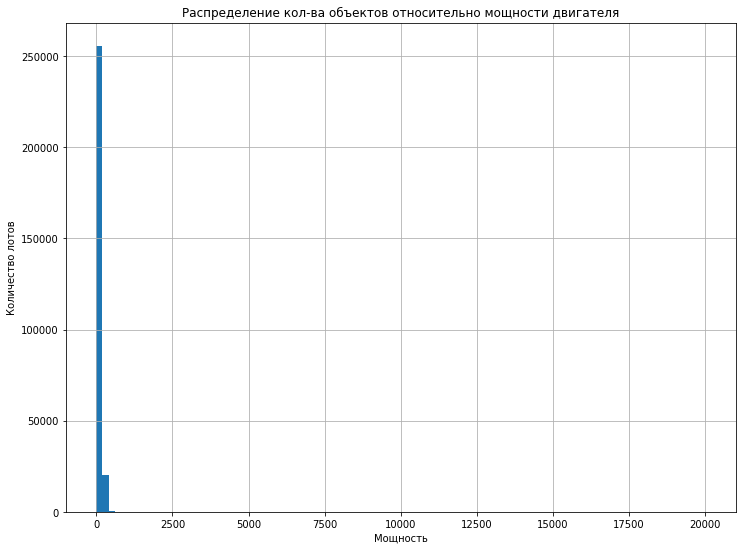

In [33]:
# давайте ещё раз посмотрим на описание данных, а также визуализируем распределение
df['Power'].hist(bins=100, figsize=(12,9))
plt.title('Распределение кол-ва объектов относительно мощности двигателя')
plt.xlabel('Мощность')
plt.ylabel('Количество лотов')
plt.show()

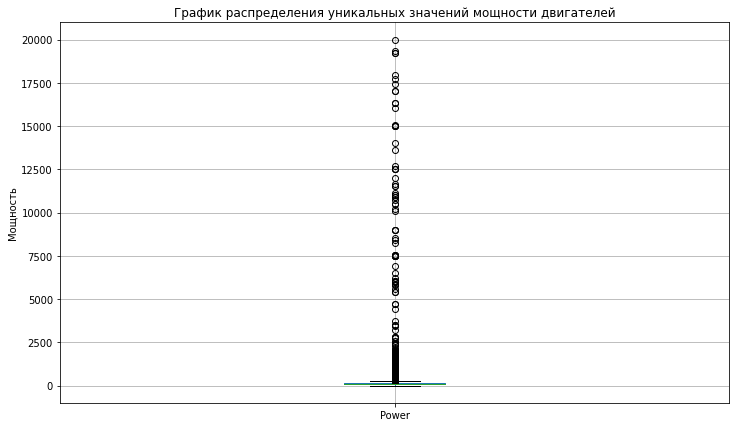

count    276718.000000
mean        114.179945
std         193.206901
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [34]:
df.boxplot(['Power'], figsize=(12,7))
plt.title('График распределения уникальных значений мощности двигателей')

plt.ylabel('Мощность')
plt.show()

df['Power'].describe()

Очевидно, что присутствуют сильные выбросы значений.  
Согласно имеющейся в интрнете инф-и, текущий рекорд мощности среди легковых автомобилей 2028 лошадиных сил (Dagger GT компании TranStar Racing LLC). Для начала ограничимся этим значением, после дополнительно скорректируем.

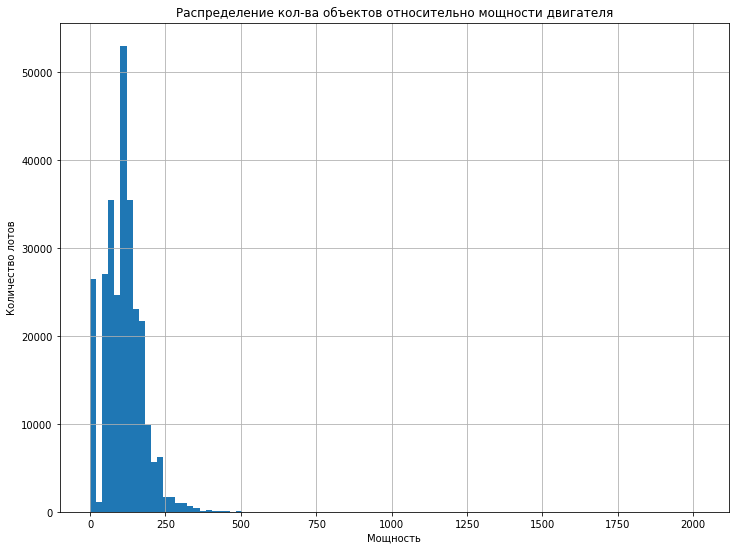

count    276634.000000
mean        111.444884
std          72.053298
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max        2018.000000
Name: Power, dtype: float64

In [35]:
df = df.query('Power < 2029')
df['Power'].hist(bins=100, figsize=(12,9))
plt.title('Распределение кол-ва объектов относительно мощности двигателя')
plt.xlabel('Мощность')
plt.ylabel('Количество лотов')
plt.show()

df['Power'].describe()

Избавимся от лотов с нулевой мощностью и опустим верхний предел до 500

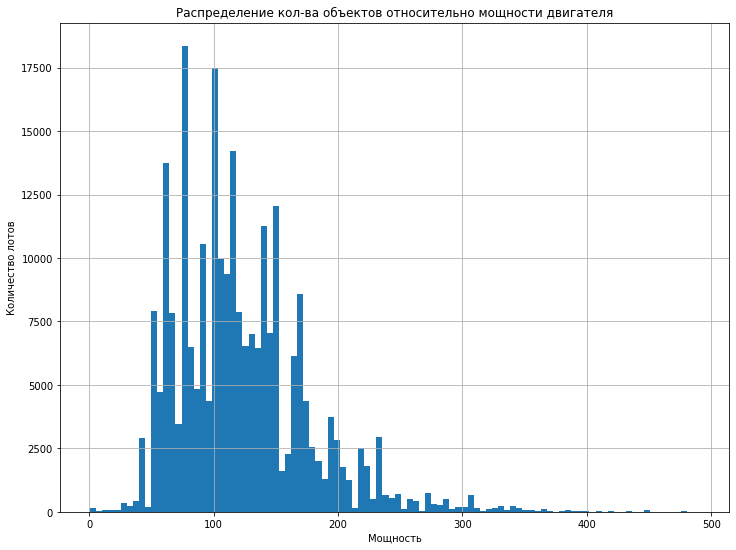

count    250239.000000
mean        121.881114
std          53.737804
min           1.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64

In [36]:
df = df.query('0 < Power < 500')
df['Power'].hist(bins=100, figsize=(12,9))
plt.title('Распределение кол-ва объектов относительно мощности двигателя')
plt.xlabel('Мощность')
plt.ylabel('Количество лотов')
plt.show()

df['Power'].describe()

In [37]:
# сбрасываем индексы после удаления объектов, проверяем информацию о получившемся датафрейме
df = df.reset_index(drop=True)
display(df.head(10))
df.info()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
0,coupe,2011,manual,190,other,125000,gasoline,audi,yes,18300
1,suv,2004,auto,163,grand,125000,gasoline,jeep,no,9800
2,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
3,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600
4,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,650
5,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2200
6,bus,2014,manual,125,c_max,30000,petrol,ford,no,14500
7,small,1998,manual,101,golf,150000,petrol,volkswagen,no,999
8,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,2000
9,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes,2799


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250239 entries, 0 to 250238
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       250239 non-null  object
 1   RegistrationYear  250239 non-null  int64 
 2   Gearbox           250239 non-null  object
 3   Power             250239 non-null  int64 
 4   Model             250239 non-null  object
 5   Kilometer         250239 non-null  int64 
 6   FuelType          250239 non-null  object
 7   Brand             250239 non-null  object
 8   Repaired          250239 non-null  object
 9   Price             250239 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 19.1+ MB


#### Преобразование признаков `Gearbox` & `Repaired` в булевые

Есть две колонки, для которых наиболе адекватным будет преобразование в булевые значения признака, это - `Gearbox` & `Repaired`.    
Так и поступим.

In [38]:
# создадим новый столбец 'ManualGearbox', где 1 - это manual, 0 - это auto
df['ManualGearbox'] = 0
df.loc[df['Gearbox'] == 'manual', 'ManualGearbox'] = 1

# считаем значения в новом и оригинальном столбце, сравниваем по количеству объектов классы
display(df['ManualGearbox'].value_counts())
df['Gearbox'].value_counts()

1    198686
0     51553
Name: ManualGearbox, dtype: int64

manual    198686
auto       51553
Name: Gearbox, dtype: int64

In [39]:
# создадим новый столбец 'Restored', где 1 - это был ремонт, 0 - это нет
df['Restored'] = 0
df.loc[df['Repaired'] == 'yes', 'Restored'] = 1

# считаем значения в новом и оригинальном столбце, сравниваем по количеству объектов классы
display(df['Restored'].value_counts())
df['Repaired'].value_counts()

0    224707
1     25532
Name: Restored, dtype: int64

no     224707
yes     25532
Name: Repaired, dtype: int64

In [40]:
# удаляем старые столбцы
df = df.drop(['Gearbox','Repaired'], axis=1)
df.info()
mem_us_o = df.memory_usage(deep=True).sum() # сохраним объём используемой памяти оригинальным df в переменную

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250239 entries, 0 to 250238
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       250239 non-null  object
 1   RegistrationYear  250239 non-null  int64 
 2   Power             250239 non-null  int64 
 3   Model             250239 non-null  object
 4   Kilometer         250239 non-null  int64 
 5   FuelType          250239 non-null  object
 6   Brand             250239 non-null  object
 7   Price             250239 non-null  int64 
 8   ManualGearbox     250239 non-null  int64 
 9   Restored          250239 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 19.1+ MB


Можно было бы преобразовать здесь все категориальные признаки в числовые, но ранее от ревьюера поступила рекомендация делать это после разделения выборок на обучающую, валидационную и тестовую.

#### Уменьшение потребляемой памяти

Сейчас у нас все цифровые признаки имеют тип int64, но мы можем использовать и другие типы целочисленных данных: int32, int16, int8. Это позволит уменьшить объём потребляемых ресурсов компьютера, тем самым ускорит обработку данных и обучение модели.  
Операция называется "Оптимизация хранения числовых данных с использованием подтипов", используем функцию `pd.to_numeric()` с параметром `downcast='integer'` для нисходящего преобразования числовых типов.

In [41]:
columns = ['RegistrationYear', 'Power', 'Kilometer', 'Price', 'ManualGearbox', 'Restored']

for column in columns:
    df[column] = pd.to_numeric(df[column], downcast='integer')
    
df.info()

mem_us_d = df.memory_usage(deep=True).sum() # сохраним объём используемой памяти downcast df в переменную
# посчитаем разницу
print('Уменьшение использования памяти на {:.2%}'.format(1 - mem_us_d/mem_us_o))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250239 entries, 0 to 250238
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       250239 non-null  object
 1   RegistrationYear  250239 non-null  int16 
 2   Power             250239 non-null  int16 
 3   Model             250239 non-null  object
 4   Kilometer         250239 non-null  int32 
 5   FuelType          250239 non-null  object
 6   Brand             250239 non-null  object
 7   Price             250239 non-null  int16 
 8   ManualGearbox     250239 non-null  int8  
 9   Restored          250239 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 10.5+ MB
Уменьшение использования памяти на 12.03%


### Выводы  
1) Данные были проанализированы, определены значимые для обучения модели признаки;  
2) В выбранном пространстве признаков были обработаны пропуски, аномалии и некорректные значения, удалены дубликаты;  
3) Частично заменены категориальные признаки на булевые;  
4) Обработали финалный датафрейм, изменив типы данных, уменьшив тем самым объём занимаемой памяти.

## Обучение моделей

### Подготовка пространства признаков и его разделение на выборки

Среди важных заказчику параметров имеются скорость обучения и скорость предсказания модели. Они оба зависят от того, на сколько оптимизированы и подготовлены данные перед обучением. Напрямую нам неуказывается на необходимость преобразования абсолютно всех категориальных признаков в числовой вид, однако очевидно, что машине удобнее работать с числовым представлением информации. Тут же возникает вопрос - каким методом кодировать категориальные данные?  

Постараемся подобрать для каждого типа категориальных данных свой тип кодирования:
* Оригинальные - original_features;  
* Закодированные методом target encoding - te_features;
* Закодированные методом oe-hot-encoding (OHE) - ohe_features.

In [42]:
# оригинальные признаки и целевой признак
original_features = df.drop('Price', axis=1)
target = df['Price']

In [43]:
# кодируем методом target encoding столбцы Brand & Model
original_features["Enc_Brand"] = original_features.groupby("Brand")["ManualGearbox"].transform("mean")
original_features["Enc_Model"] = original_features.groupby("Model")["ManualGearbox"].transform("mean")

In [44]:
# удаляем ненужные оригинальные столбцы
original_features = original_features.drop(['Brand','Model'], axis=1)

display(original_features.head(5))

,VehicleType,RegistrationYear,Power,Kilometer,FuelType,ManualGearbox,Restored,Enc_Brand,Enc_Model
0,coupe,2011,190,125000,gasoline,1,1,0.692110,0.779183
1,suv,2004,163,125000,gasoline,0,0,0.348231,0.379455
2,small,2001,75,150000,petrol,1,0,0.864954,0.877871
3,small,2008,69,90000,gasoline,1,0,0.885981,0.950120
4,sedan,1995,102,150000,petrol,1,1,0.682595,0.790228


In [45]:
# деление на обучающую и тестовую выборки
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=12345)

In [46]:
# масштабируем числовые данные
# список числовых колонок за исключением булевых 
num_col = ['RegistrationYear','Power','Kilometer']

# обучаем
scaler = StandardScaler()
scaler.fit(original_features_train[num_col])

# масштабируем выборки
original_features_train[num_col] = scaler.transform(original_features_train[num_col])
original_features_test[num_col] = scaler.transform(original_features_test[num_col])

display(original_features_train.head())
print('Обущающая выборка в процентах: {:.2%}'.format(original_features_train.shape[0] / original_features.shape[0]))
display(original_features_test.head())
print('Обущающая выборка в процентах: {:.2%}'.format(original_features_test.shape[0] / original_features.shape[0]))

,VehicleType,RegistrationYear,Power,Kilometer,FuelType,ManualGearbox,Restored,Enc_Brand,Enc_Model
124401,small,-1.660437,-0.127726,0.613573,petrol,1,0,0.891222,0.922822
74446,small,0.376859,-0.463078,-1.793114,petrol,1,0,0.793029,0.949612
34416,small,-0.250001,-1.469135,0.613573,petrol,1,0,0.891222,0.942231
243794,sedan,0.847004,0.393933,0.613573,gasoline,1,0,0.682595,0.868690
98152,wagon,1.473864,0.002689,-1.793114,petrol,1,1,0.864954,0.757919


Обущающая выборка в процентах: 75.00%


,VehicleType,RegistrationYear,Power,Kilometer,FuelType,ManualGearbox,Restored,Enc_Brand,Enc_Model
238564,coupe,0.847004,0.896961,0.613573,petrol,0,0,0.692110,0.583524
174863,convertible,-0.876861,-0.258141,0.613573,petrol,1,0,0.937724,0.934312
205280,small,-0.406716,-0.593493,0.613573,petrol,1,0,0.891222,0.950963
128017,suv,0.533574,1.903018,0.613573,gasoline,0,0,0.864954,0.187500
1771,wagon,0.847004,0.393933,0.613573,petrol,1,0,0.692110,0.742147


Обущающая выборка в процентах: 25.00%


In [47]:
# приступим к по-выборочному кодированию категориальных признаков
encod_features_train = original_features_train.copy()
encod_features_test = original_features_test.copy()

In [49]:
# Остальные категориальные признаки можно закодировать OHE
def ohe_enc(data, column):
    df = pd.get_dummies(data[column], prefix=column, drop_first=True)
    data = data.drop(column, axis=1)
    return data.join(df)

In [50]:
columns = ['VehicleType','FuelType']
encod_features_train = ohe_enc(encod_features_train, 'VehicleType')
encod_features_test = ohe_enc(encod_features_test, 'VehicleType')
encod_features_train = ohe_enc(encod_features_train, 'FuelType')
encod_features_test = ohe_enc(encod_features_test, 'FuelType')

display(encod_features_train.head(5))
display(encod_features_test.head(5))

,RegistrationYear,Power,Kilometer,ManualGearbox,Restored,Enc_Brand,Enc_Model,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
124401,-1.660437,-0.127726,0.613573,1,0,0.891222,0.922822,0,0,0,0,1,0,0,0,0,0,0,0,1
74446,0.376859,-0.463078,-1.793114,1,0,0.793029,0.949612,0,0,0,0,1,0,0,0,0,0,0,0,1
34416,-0.250001,-1.469135,0.613573,1,0,0.891222,0.942231,0,0,0,0,1,0,0,0,0,0,0,0,1
243794,0.847004,0.393933,0.613573,1,0,0.682595,0.868690,0,0,0,1,0,0,0,0,1,0,0,0,0
98152,1.473864,0.002689,-1.793114,1,1,0.864954,0.757919,0,0,0,0,0,0,1,0,0,0,0,0,1


,RegistrationYear,Power,Kilometer,ManualGearbox,Restored,Enc_Brand,Enc_Model,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
238564,0.847004,0.896961,0.613573,0,0,0.692110,0.583524,0,1,0,0,0,0,0,0,0,0,0,0,1
174863,-0.876861,-0.258141,0.613573,1,0,0.937724,0.934312,1,0,0,0,0,0,0,0,0,0,0,0,1
205280,-0.406716,-0.593493,0.613573,1,0,0.891222,0.950963,0,0,0,0,1,0,0,0,0,0,0,0,1
128017,0.533574,1.903018,0.613573,0,0,0.864954,0.187500,0,0,0,0,0,1,0,0,1,0,0,0,0
1771,0.847004,0.393933,0.613573,1,0,0.692110,0.742147,0,0,0,0,0,0,1,0,0,0,0,0,1


### Подготовка моделей и проведение испытаний

#### Линейная регрессия

In [64]:
%%time

regressor = LinearRegression()
print('# Train LR for root_mean_squared_error')
print()
cv_rmse_lr = (cross_val_score(regressor, 
                             encod_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression on ordianl encoding features =', cv_rmse_lr)

# Train LR for root_mean_squared_error

Mean RMSE from CV of LinearRegression on ordianl encoding features = 2895.4698776401883
CPU times: user 692 ms, sys: 767 ms, total: 1.46 s
Wall time: 1.36 s


In [65]:
%%time

# попробуем масштабирование признаков
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('#Train LR scalled features for root_mean_squared_error')
print()
cv_rmse_lr_s = (cross_val_score(pipeline,
                                encod_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression on one-hot encoding scalled features =', cv_rmse_lr_s)

#Train LR scalled features for root_mean_squared_error

Mean RMSE from CV of LinearRegression on one-hot encoding scalled features = 2895.4698776401883
CPU times: user 978 ms, sys: 850 ms, total: 1.83 s
Wall time: 1.78 s


##### Вывод  
Масштабирование не повлияло на результат предсказаний, но потребовало на 0.18 секунды больше времени.

#### Решающее дерево

In [66]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 20)] # однострочный цикл для значений в указанном диапазоне
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

# подбираем гиперпараметры модели
print('# Tuning hyper-parameters of DecissionTree model for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(encod_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
# будем запрашивать нужные нам переменные из clf
mean_val = clf.cv_results_['mean_test_score']
std_val = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_val, std_val, clf.cv_results_['params']): # zip нужен для склеивания разных парамтеров в список
    print("%0.2f for %r"% ((mean*-1)** 0.5, params))
print()

cv_rmse_dtr = (max(mean_val)*-1) ** 0.5
print(cv_rmse_dtr)

# Tuning hyper-parameters of DecissionTree model for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}

Grid scores on development set:

3156.25 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2804.58 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2543.08 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2377.45 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2258.36 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2158.14 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2072.35 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
2002.37 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1945.06 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1909.84 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1882.28 for {'criterion': 'mse', 'max_depth': 12, 'random_

##### Вывод  
Лучший результат равен 1880.62, при параметрах {'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}

#### CatBoostRegressor

Можно ознакомиться с материалами:  
* https://habr.com/ru/companies/otus/articles/527554/
* https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/tiuning-catboost-gradientnogo-bustinga-ot-iandeks-60fbefbf3b939a51fa258d80

In [68]:
%%time

# Модель на закодированных данных

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(encod_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
mean_val = clf.cv_results_['mean_test_score']
std_val = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_val, std_val, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1)** 0.5, params))
print()

cv_rmse_cbr_encod = (max(mean_val)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

Grid scores on development set:

1605.48 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1606.77 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1634.98 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

CPU times: user 5min 34s, sys: 1.57 s, total: 5min 35s
Wall time: 5min 53s


##### Вывод  
Лучший показатель RMSE равен 1605.48 у модели, обученной на преобразованном пространстве признаков.

#### LGBM

In [67]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[12345]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(encod_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
mean_val = clf.cv_results_['mean_test_score']
std_val = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_val, std_val, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1)** 0.5, params))
print()

cv_rmse_lgbmr = (max(mean_val)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}

Grid scores on development set:

1696.81 for {'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 12345}
1612.95 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 12345}
1597.54 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}

CPU times: user 21min, sys: 3.91 s, total: 21min 3s
Wall time: 21min 13s


##### Вывод  
Наилучший показатель целевого параметра RMSE составляет 1615.76.

### Предсказание на лучших параметрах

#### Линейная регрессия

In [57]:
%%time

model = LinearRegression()
model.fit(encod_features_train, target_train)

CPU times: user 155 ms, sys: 55.1 ms, total: 211 ms
Wall time: 161 ms


LinearRegression()

In [58]:
%%time

target_predict = model.predict(encod_features_test)
pred_rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 21.3 ms, sys: 19.6 ms, total: 41 ms
Wall time: 90.9 ms


#### Решающее дерево

In [59]:
%%time

# Модель на принаках, закодированных по методу OHE
model_dt = DecisionTreeRegressor(criterion='mse', 
                              max_depth=14, 
                              random_state=12345) 
model_dt.fit(encod_features_train, target_train)

CPU times: user 662 ms, sys: 66.8 ms, total: 729 ms
Wall time: 790 ms


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [60]:
%%time
target_predict = model_dt.predict(encod_features_test)
pred_rmse_dtr = mean_squared_error(target_test, target_predict) ** 0.5 

CPU times: user 15 ms, sys: 16 µs, total: 15 ms
Wall time: 14.1 ms


#### CatBoost

In [61]:
%%time

model_cbr = CatBoostRegressor(learning_rate=0.1, 
                          random_state=12345, 
                          verbose=False) 
model_cbr.fit(encod_features_train, target_train)

CPU times: user 24.5 s, sys: 100 ms, total: 24.6 s
Wall time: 25.7 s


In [62]:
%%time

target_predict = model_cbr.predict(encod_features_test)
pred_rmse_cbr = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 65.5 ms, sys: 782 µs, total: 66.3 ms
Wall time: 64.6 ms


#### LGBM

In [54]:
%%time

model_lgbm = LGBMRegressor(learning_rate=0.3, 
                      num_leaves=100, 
                      random_state=12345)
model_lgbm.fit(encod_features_train, target_train)

CPU times: user 7min 12s, sys: 1.3 s, total: 7min 14s
Wall time: 7min 16s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=12345)

In [55]:
%%time

target_predict = model_lgbm.predict(encod_features_test)
pred_rmse_lgbm = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 577 ms


Все данные собраны, можно их собрать в единую таблицу для наглядности и сделать общий вывод.

## Анализ моделей

In [69]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_rmse_lr,
                            cv_rmse_dtr,
                            cv_rmse_cbr_encod,
                            cv_rmse_lgbmr],
        'Время обучения на CV, сек':[1.67,
                                     32.2,
                                     305,
                                     65],
        'RMSE модели на тестовой выборке, евро':[pred_rmse_lr,
                                                pred_rmse_dtr,
                                                pred_rmse_cbr,
                                                pred_rmse_lgbm],
        'Время обучения модели, сек':[0.199,
                                      0.532,
                                      22.7,
                                      13.5],
        'Время предсказания модели, сек':[0.016,
                                          0.015,
                                          0.059,
                                          0.404]}

scores_table = pd.DataFrame(data=data, index=index)
scores_table

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек"
LinearRegression,2895.469878,1.67,2886.683622,0.199,0.016
DecisionTreeRegressor,1871.998831,32.20,1817.146673,0.532,0.015
CatBoostRegressor,1605.482966,305.00,1575.341884,22.700,0.059
LGBMRegressor,1597.544230,65.00,1561.063457,13.500,0.404


### Вывод  
По таблице отчётливо видно, что наилучшими показателями обладают 2 модели: `CatBoost` и `LGBM`, но время, точность первой даже выше, можно считать, что целевому показателю RMSE она ближе всех к победе. Но по затрачиваемому времени на обучение она сильно уступает `LGBM`, практически в 2 раза.  
**Рекомендую к использованию `CatBoost`**, так как по RMSE она точнее `LGBM`, также время на обучение требуется в 2 раза больше, но время предсказывания в 8 быстрее.

## Общие выводы по проекту  

Перед нами стояла задача - построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения.  
В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях `CatBoost Regressor` и `LightGBM Regressor`, и сравнили её с базовыми моделями `Linear Regression` и `DecisionTree Regressor`.

По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от `CatBoost Regressor` побеждает модель `LightGBM Regressor`, но сильно уступает по скорости обучения, в скорости предсказания также лидирует `CatBoost Regressor`.  

Лучший показатель работы модели по RMSE равен 1561.06 c временем обучения 13.5 с, временем предсказания 0.404 с.
RMSE `CatBoost Regressor` 1575.34, время обучения 22.7 с, время предсказания 0.059с.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель `CatBoostRegressor`, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении высоких показателей по качеству предсказания.